In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import numpy as np
import ast
from scipy.stats import spearmanr

# Reading in and preprocess the data by deleting useless columns and converting coded strings to ints

df = pd.read_csv('youtube1000.csv')

df = df.drop(columns=['contentDetails.dimension', 'contentDetails.projection','etag', 'id',
                     'kind','snippet.channelId', 'snippet.thumbnails.default.height',
                     'snippet.thumbnails.default.url', 'snippet.thumbnails.default.width',
                     'snippet.thumbnails.high.height', 'snippet.thumbnails.high.url',
                     'snippet.thumbnails.high.width', 'snippet.thumbnails.maxres.height',
                     'snippet.thumbnails.maxres.url', 'snippet.thumbnails.maxres.width',
                     'snippet.thumbnails.medium.height', 'snippet.thumbnails.medium.url',
                     'snippet.thumbnails.medium.width', 'snippet.thumbnails.standard.height',
                     'snippet.thumbnails.standard.url', 'snippet.thumbnails.standard.width',
                      'snippet.defaultAudioLanguage', 'snippet.defaultLanguage',
                      'snippet.liveBroadcastContent', 'snippet.title', 'Unnamed: 0', 
                      'snippet.localized.description', 'snippet.localized.title',
                      'snippet.description', 'snippet.channelTitle', 'statistics.favoriteCount'
                     ])


df=df.rename(columns = {'statistics.dislikeCount':'dislikeCount'})
df=df.rename(columns = {'statistics.commentCount':'commentCount'})
df=df.rename(columns = {'statistics.likeCount':'likeCount'})
df=df.rename(columns = {'statistics.viewCount':'viewCount'})
df=df.rename(columns = {'snippet.categoryId':'catID'})
df=df.rename(columns = {'contentDetails.licensedContent':'licensed'})



print(df.shape)
print(df.columns)
print(df.describe())



(1000, 12)
Index(['search_word', 'contentDetails.caption', 'contentDetails.definition',
       'contentDetails.duration', 'licensed', 'catID', 'snippet.publishedAt',
       'snippet.tags', 'commentCount', 'dislikeCount', 'likeCount',
       'viewCount'],
      dtype='object')
             catID   commentCount  dislikeCount     likeCount     viewCount
count  1000.000000     963.000000  9.900000e+02  9.900000e+02  9.970000e+02
mean     20.248000   11468.477674  8.526747e+03  1.502547e+05  1.576084e+07
std       6.927517   53501.023334  5.519503e+04  7.402962e+05  9.327645e+07
min       1.000000       0.000000  0.000000e+00  0.000000e+00  4.800000e+01
25%      17.000000      89.500000  2.700000e+01  5.800000e+02  3.003100e+04
50%      22.000000     549.000000  2.055000e+02  3.794000e+03  2.345960e+05
75%      25.000000    2981.000000  1.732000e+03  2.818075e+04  2.433079e+06
max      30.000000  691263.000000  1.242881e+06  9.982215e+06  1.554095e+09


In [2]:
# Address Null values. Utilized mean value to address missing continuous data
# Convert and drop snippet.tags, date columns.   

df['commentCount'].fillna((df['commentCount'].mean()), inplace=True)
df['dislikeCount'].fillna((df['dislikeCount'].mean()), inplace=True)
df['likeCount'].fillna((df['likeCount'].mean()), inplace=True)
df['viewCount'].fillna((df['viewCount'].mean()), inplace=True)
df['snippet.tags'].fillna('[]', inplace=True)

#Convert snippet.tags into length for continuous data
df['tags_length'] = [len(ast.literal_eval(row)) for row in df['snippet.tags']]
df = df.drop(columns=['snippet.tags'])




1554094588.0
    search_word  contentDetails.caption contentDetails.definition  \
276       music                   False                        hd   
286       music                    True                        hd   
258       music                    True                        hd   
260       music                   False                        hd   
267       music                   False                        hd   
261       music                   False                        hd   
265       music                   False                        hd   
282       music                    True                        hd   
269       music                   False                        hd   
270       music                    True                        hd   
384      sports                    True                        hd   

    contentDetails.duration  licensed  catID       snippet.publishedAt  \
276                 PT3M45S      True     10  2017-07-07T09:00:05.000Z   
286       

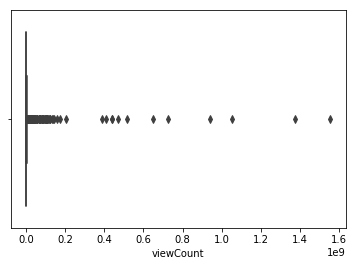

In [3]:
sns.boxplot(df['viewCount'])

print(df['viewCount'].max())

print(df.sort_values('viewCount',ascending = False).head(11))



In [4]:
print('Since there only 11 outliers, almost all from music category, we will remove them')
df1 = df.sort_values('viewCount',ascending = False).head(11)
df = df.drop(index=df1.index)

Since there only 11 outliers, almost all from music category, we will remove them


In [5]:
bucket = []
for i in range(8000):  
    bucket.append((i*50000))


# Bucketize the dependent variable / viewCount
df['view_bucket'] = pd.cut(df['viewCount'], bucket, 
                           include_lowest=True, labels=list(range(1, 8000)))
df['view_bucket'] = df['view_bucket'].astype(float)
df = df.drop(columns=['viewCount'])


In [6]:
#Converts published date into date time object and sort df by date

df['date'] =  pd.to_datetime(df['snippet.publishedAt'], format='%Y-%m-%dT%H:%M:%S.000Z', utc=True)
df.sort_values(by='date')

df = df.drop(columns=['snippet.publishedAt'])

# Converts all durations into a standard unit of seconds
s = df['contentDetails.duration']
multiplication = [3600, 60, 1, 60, 1, 60, 1]
test_list = []
for item in s:
    r = re.search(r'(\d*)H(\d*)M(\d*)S|(\d*)M(\d*)S|(\d*)M|(\d*)S', item, re.I)
    resp = list(r.groups(0)) 
    resp = [int(num) for num in resp]
    test = sum([item*time_duration for item, time_duration in zip(resp, multiplication)])
    test_list.append(test)
df['duration'] = test_list    

# Drop off the original duration column since it is now not required 
df = df.drop(columns=['contentDetails.duration'])
    

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 999
Data columns (total 12 columns):
search_word                  989 non-null object
contentDetails.caption       989 non-null bool
contentDetails.definition    989 non-null object
licensed                     989 non-null bool
catID                        989 non-null int64
commentCount                 989 non-null float64
dislikeCount                 989 non-null float64
likeCount                    989 non-null float64
tags_length                  989 non-null int64
view_bucket                  989 non-null float64
date                         989 non-null datetime64[ns, UTC]
duration                     989 non-null int64
dtypes: bool(2), datetime64[ns, UTC](1), float64(4), int64(3), object(2)
memory usage: 86.9+ KB


,search_word,contentDetails.caption,contentDetails.definition,licensed,catID,commentCount,dislikeCount,likeCount,tags_length,view_bucket,date,duration
0,Siemens,False,hd,True,27,117.000000,80.0,931.0,29,2.0,2018-01-08 11:53:47+00:00,688
1,Siemens,False,hd,False,28,11468.477674,7.0,70.0,11,1.0,2017-11-20 19:18:50+00:00,199
2,Siemens,False,hd,False,28,11468.477674,52.0,731.0,11,5.0,2013-08-28 11:07:01+00:00,160
3,Siemens,False,hd,False,28,11468.477674,204.0,3835.0,8,4.0,2018-10-16 12:37:42+00:00,264
4,Siemens,False,hd,True,26,64.000000,23.0,718.0,14,1.0,2018-11-27 20:11:59+00:00,1663


There are more videos aggregated around 2019.  Since the searches were performed recently,this means that more recently published videos are more relevent.
There does not appear to be a linear or any relationship  between publish date and views.
For simplicity purposes, I will not consider publish date in the linear model


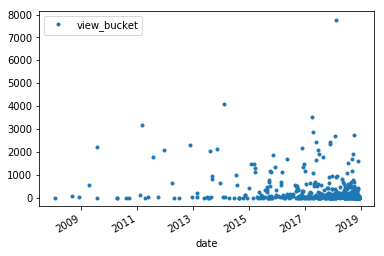

In [8]:

#plt.title('Published date vs. view_bucket')
df.plot(x='date', y='view_bucket', style=".")
print('There are more videos aggregated around 2019.  Since the searches were performed recently,this means that more recently published videos are more relevent.')
print('There does not appear to be a linear or any relationship  between publish date and views.')
print('For simplicity purposes, I will not consider publish date in the linear model')

Average length of a video in seconds 1389.9817997977755
Maximum length of a video in seconds is 42112


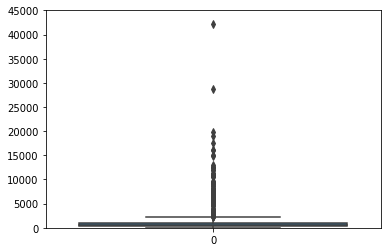

In [9]:
sns.boxplot(data=df['duration'])
plt.ylim(0, 45000)
print('Average length of a video in seconds ' + str(df['duration'].mean()))
print('Maximum length of a video in seconds is ' + str(df['duration'].max()))



There does not appear to be relationship between video duration and view count


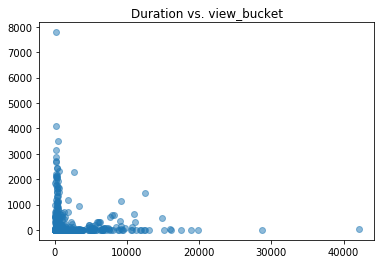

In [10]:

plt.scatter(df['duration'], df['view_bucket'], alpha=0.5)
plt.title('Duration vs. view_bucket')
print('There does not appear to be relationship between video duration and view count')


Spearmans correlation coefficient: -0.001
Duration and views are uncorrelated (fail to reject H0) p=0.973
Since correlation does not exist, will remove duration from consideration.


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


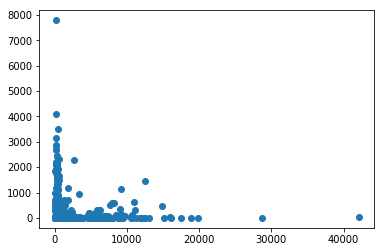

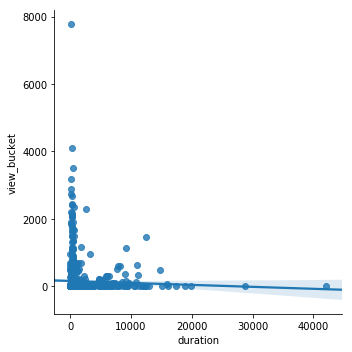

In [11]:
# Perform correlation test on duration vs. views 
plt.scatter(df['duration'], df['view_bucket'])
sns.lmplot(x='duration', y='view_bucket', data=df)

coef, p = spearmanr(df['duration'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Duration and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Duration and views are correlated (reject H0) p=%.3f' % p)
    

print('Since correlation does not exist, will remove duration from consideration.')
df = df.drop(columns=['duration'])

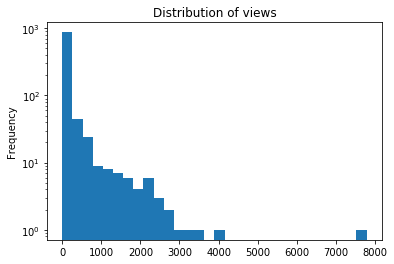

Average view_bucket for all 1000 videos 145.93
Observation: One more outlier is observed


In [12]:
# Distribution of views.  Most frequency appears in under 200,000 views
df['view_bucket'].plot.hist(bins =30)
plt.title('Distribution of views')
plt.yscale('log')
plt.xscale('linear')
plt.show()

print('Average view_bucket for all 1000 videos ' + str(round(df['view_bucket'].mean(),2)))
print('Observation: One more outlier is observed')





[None]

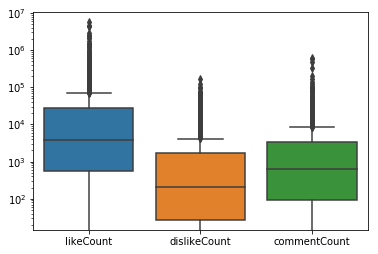

In [13]:
#Univariate Analysis - boxplot shows likeCounts tends to be higher
stats_df = df[['likeCount', 'dislikeCount', 'commentCount']].copy()
ax = sns.boxplot(data=stats_df)
ax.set(yscale="log")

Licensed content does not have relationship w/ views
   licensed  view_bucket
0     False          151
1      True          144
    index     search_word  view_bucket
4       4    dude perfect          944
14     14           music          894
1       1            cats          355
13     13          movies          153
15     15          python          115
10     10             mac           99
2       2       christmas           96
3       3    donald trump           92
18     18        vacation           85
17     17          sports           33
8       8          iphone           32
7       7          horror           28
5       5          gaming           27
9       9           laugh           27
6       6            golf           22
12     12       minecraft           18
11     11            mars           13
19     19  video blogging           10
16     16        speedrun            9
0       0         Siemens            3
    index  catID  view_bucket
2       2     10       

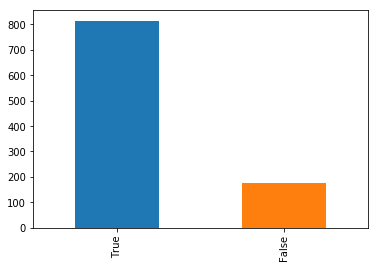

In [14]:
# Analysis of average view count based on licensed content and also search_word
print('Licensed content does not have relationship w/ views') 
df['licensed'].value_counts().plot(kind='bar')

pd.set_option('display.float_format', lambda x: '%i' % x)
print(df.groupby('licensed', as_index=False)['view_bucket'].mean())
grouped_search = df.groupby('search_word', as_index=False)['view_bucket'].mean().reset_index()
print(grouped_search.sort_values('view_bucket', ascending=False))

grouped_id = df.groupby('catID', as_index=False)['view_bucket'].mean().reset_index()
print(grouped_id.sort_values('view_bucket', ascending=False))

print('Search word and video category have strong relationship w/ views ')

# most categoryID views - music, Sports, Pets and Animals


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


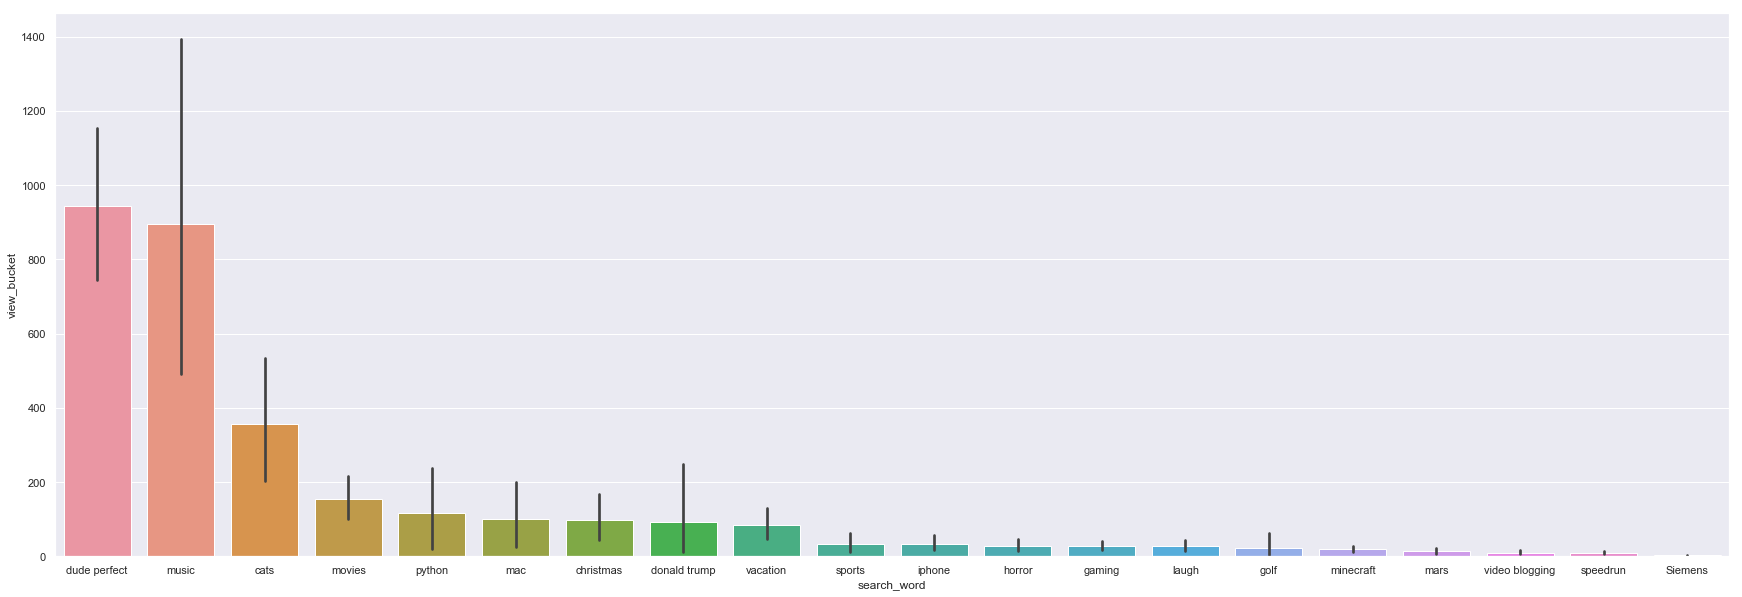

In [15]:
# Bi-variate Analysis


result = df.groupby(["search_word"])['view_bucket'].aggregate(np.mean).reset_index().sort_values('view_bucket', ascending=False)

sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(x='search_word',y='view_bucket', data=df, order=result['search_word'])




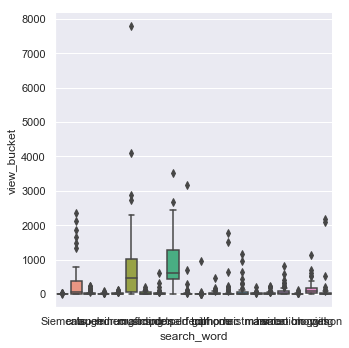

In [16]:
sns.set(rc={'figure.figsize':(100,10)})
sns.catplot(x="search_word", y="view_bucket", kind="box", data=df);

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


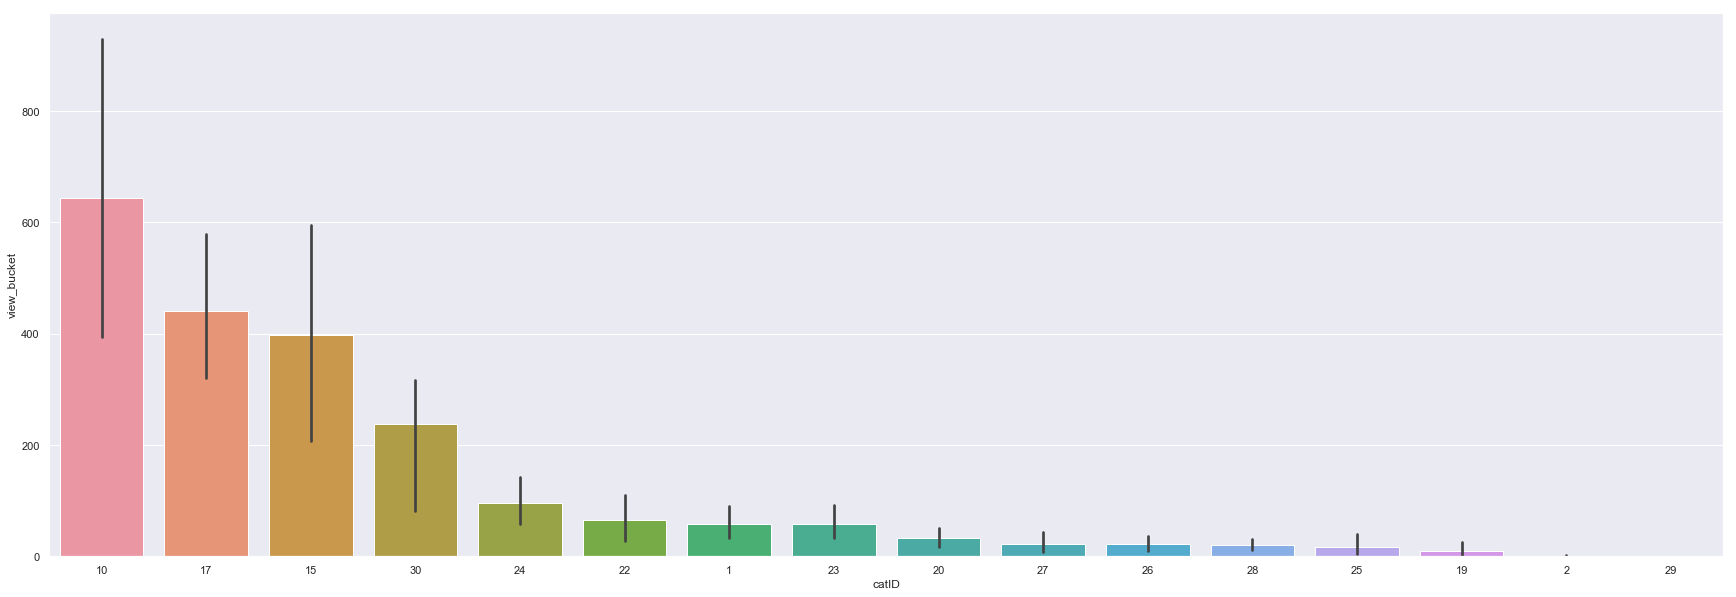

In [17]:
result = df.groupby(['catID'])['view_bucket'].aggregate(np.mean).reset_index().sort_values('view_bucket', ascending=False)

sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(x='catID',y='view_bucket', data=df, order=result['catID'])


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: -0.236
Category ID and views are correlated (reject H0) p=0.000


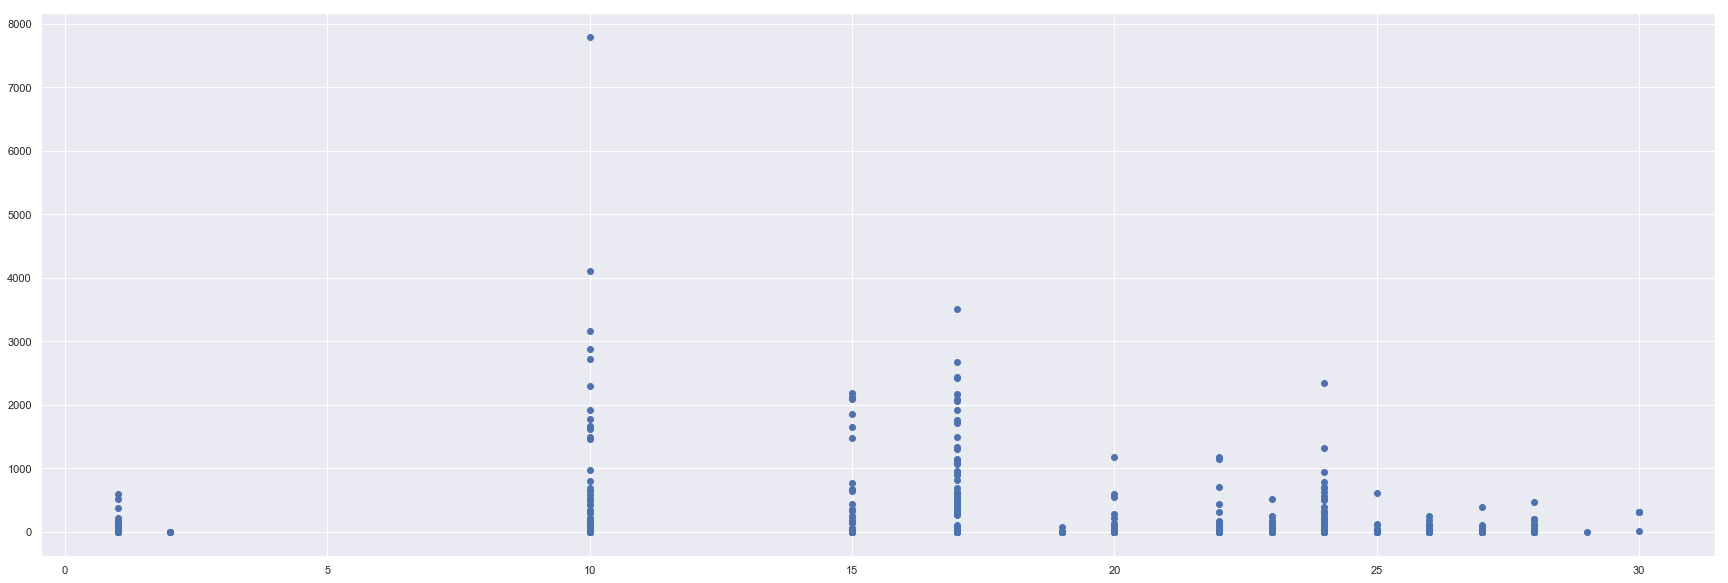

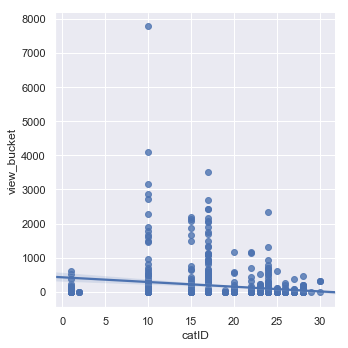

In [18]:
plt.scatter(df['catID'], df['view_bucket'])
sns.lmplot(x='catID', y='view_bucket', data=df)

coef, p = spearmanr(df['catID'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Category ID and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Category ID and views are correlated (reject H0) p=%.3f' % p)

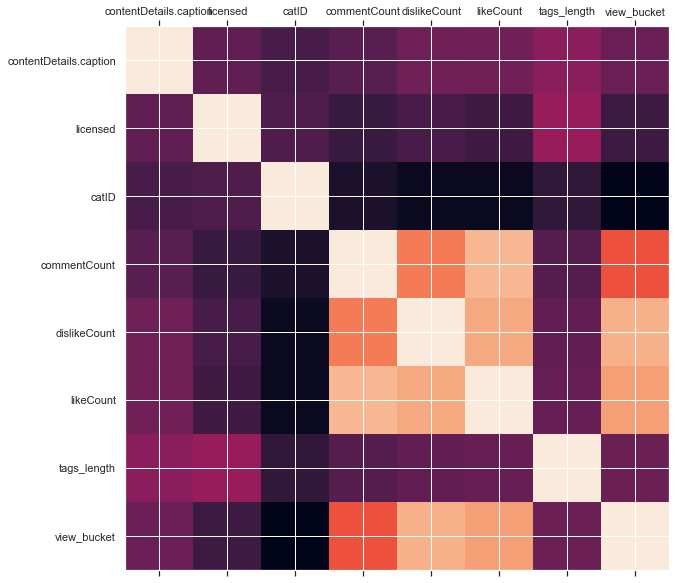

In [19]:


def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(df)

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: 0.889
LikeCount and views are correlated (reject H0) p=0.000


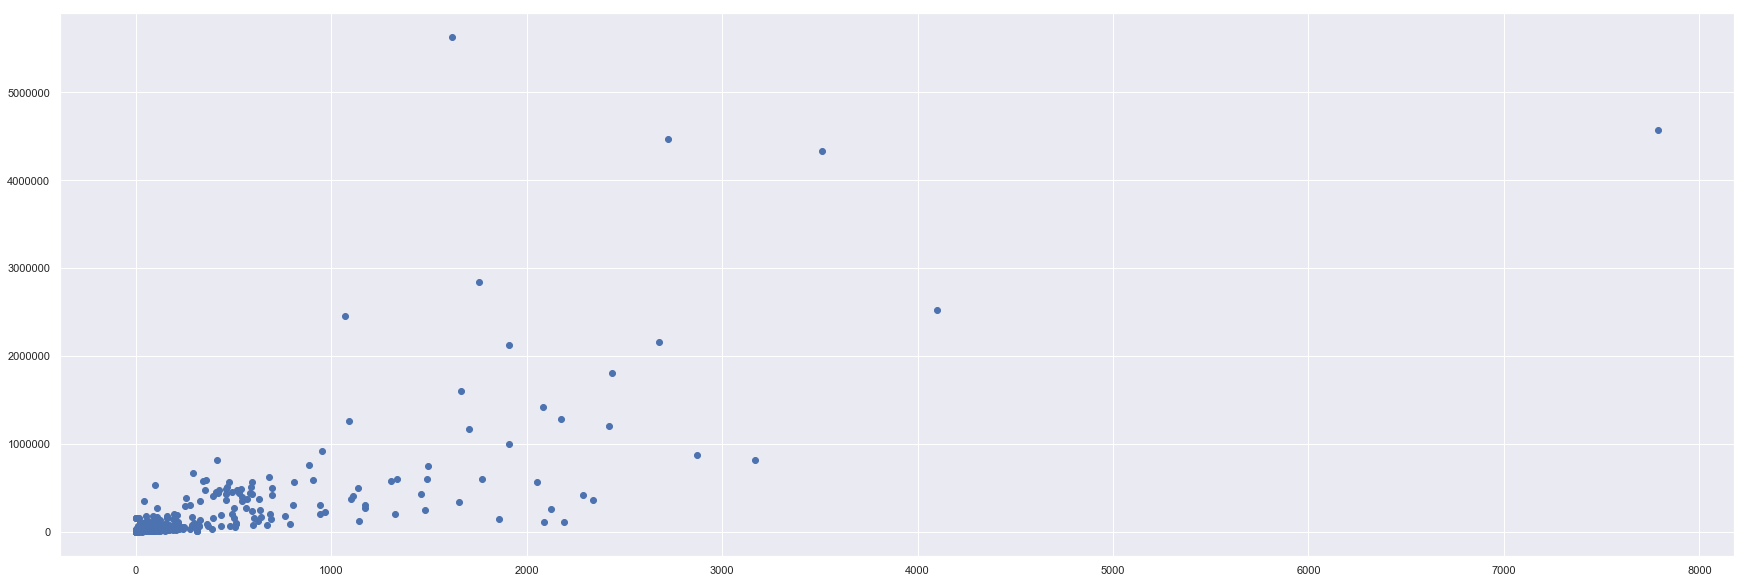

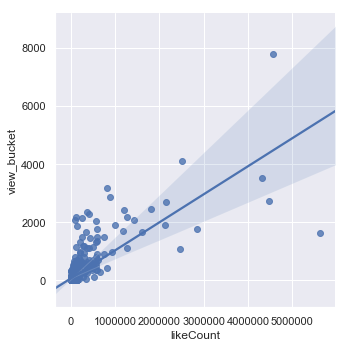

In [20]:
# Dependence test on continuous data

from scipy.stats import spearmanr

plt.scatter(df['view_bucket'], df['likeCount'])
sns.lmplot(x='likeCount', y='view_bucket', data=df)

coef, p = spearmanr(df['likeCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('LikeCount and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('LikeCount and views are correlated (reject H0) p=%.3f' % p)

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: 0.172
Snippet tag lengths and views are correlated (reject H0) p=0.000


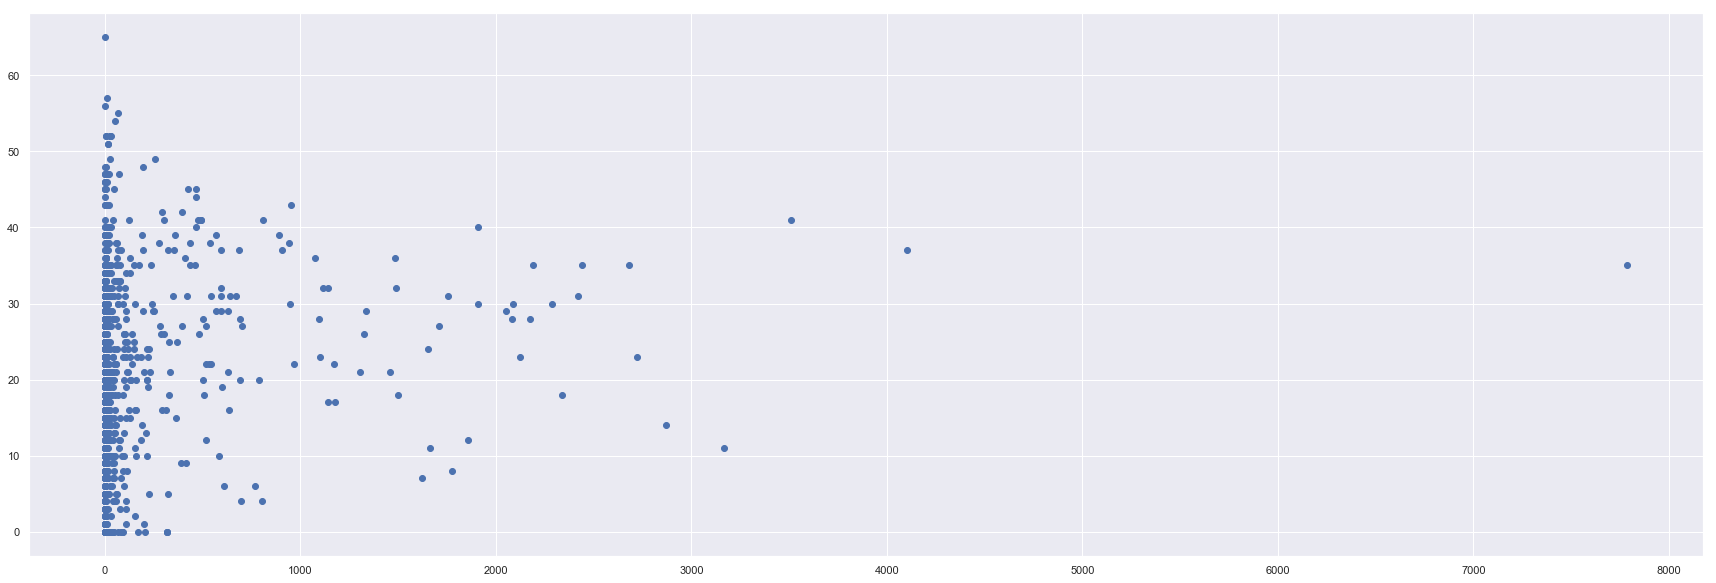

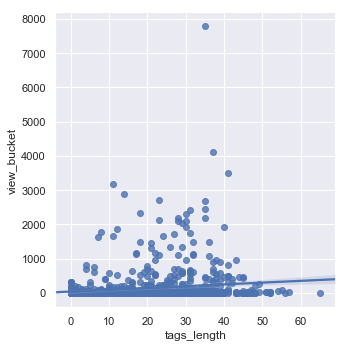

In [21]:
# Dependence test on continuous data


plt.scatter(df['view_bucket'], df['tags_length'])
sns.lmplot(x='tags_length', y='view_bucket', data=df)

coef, p = spearmanr(df['tags_length'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Snippet tag lengths and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Snippet tag lengths and views are correlated (reject H0) p=%.3f' % p)

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: 0.926
Dislike count and views are correlated (reject H0) p=0.000


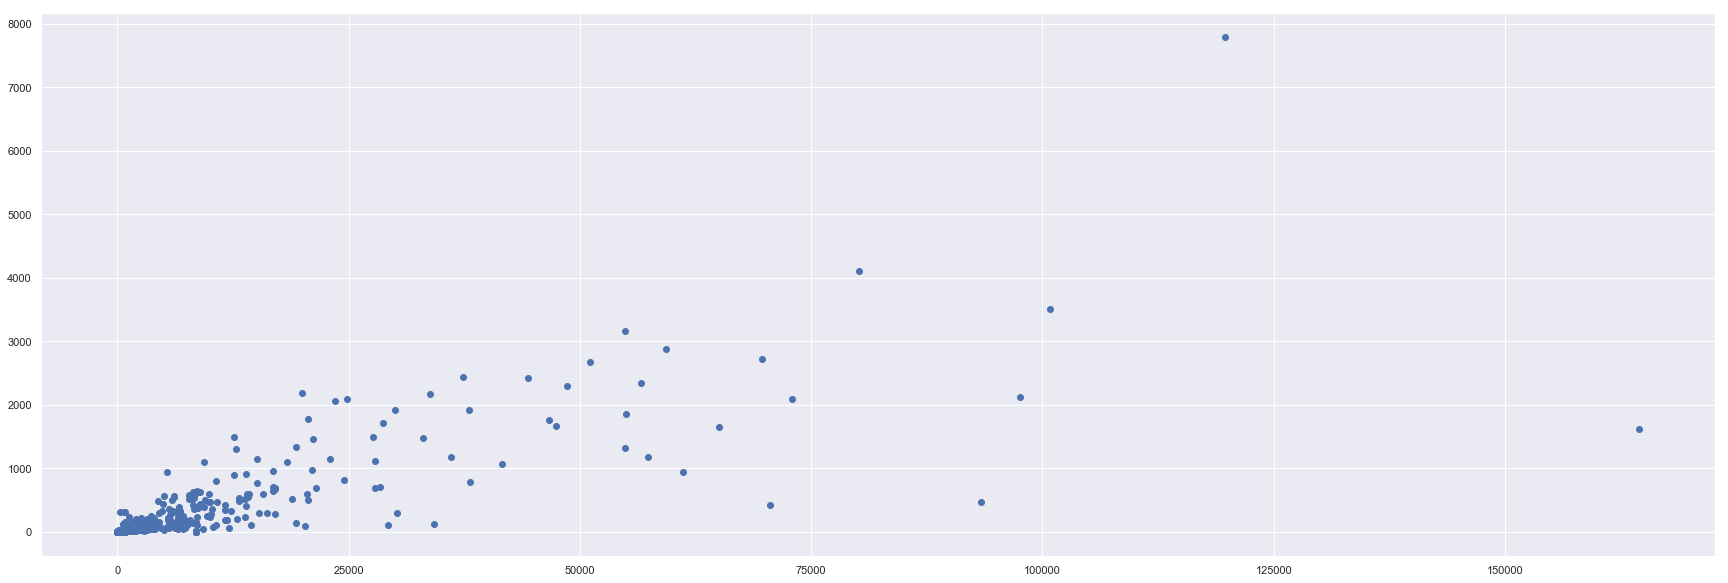

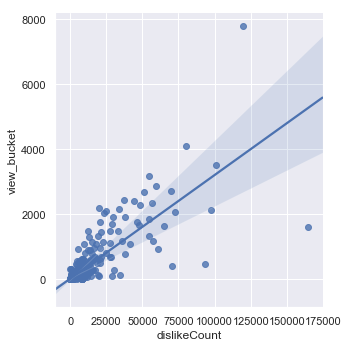

In [22]:
plt.scatter(df['dislikeCount'], df['view_bucket'])
sns.lmplot(x='dislikeCount', y='view_bucket', data=df)

coef, p = spearmanr(df['dislikeCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Dislike count and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Dislike count and views are correlated (reject H0) p=%.3f' % p)

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: 0.753
Comment count and views are correlated (reject H0) p=0.000


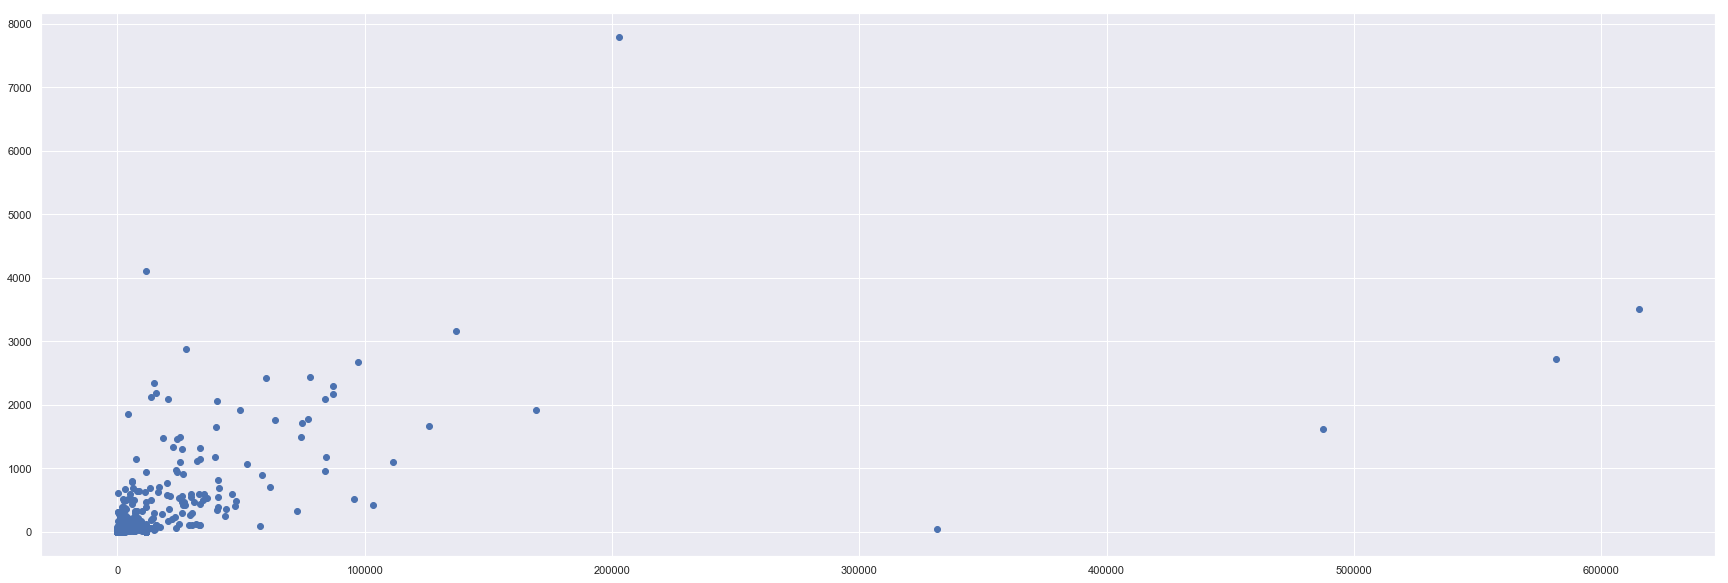

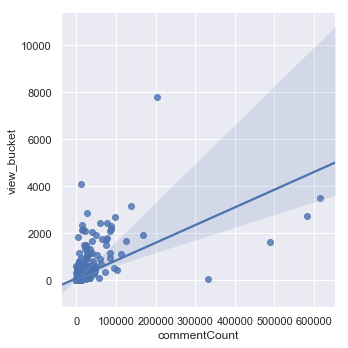

In [23]:
plt.scatter(df['commentCount'], df['view_bucket'])
sns.lmplot(x='commentCount', y='view_bucket', data=df)

coef, p = spearmanr(df['commentCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Comment count and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Comment count and views are correlated (reject H0) p=%.3f' % p)

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Spearmans correlation coefficient: 0.036
Licensed content and views are uncorrelated (fail to reject H0) p=0.262


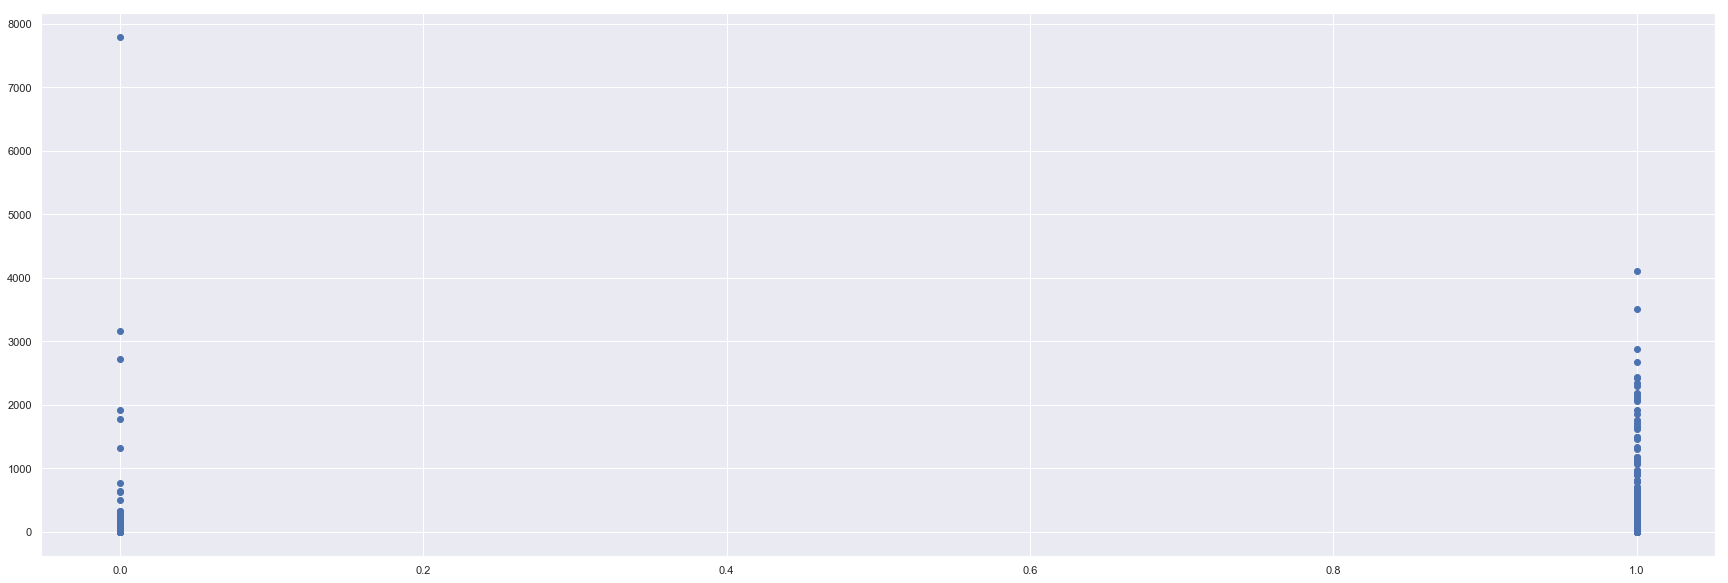

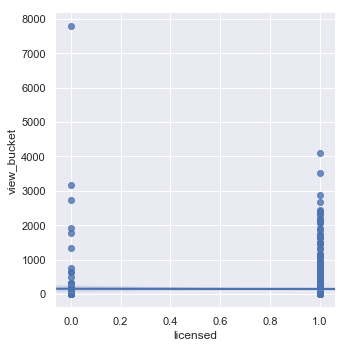

In [24]:
plt.scatter(df['licensed'], df['view_bucket'])
sns.lmplot(x='licensed', y='view_bucket', data=df)

coef, p = spearmanr(df['licensed'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Licensed content and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Licensed content and views are correlated (reject H0) p=%.3f' % p)




In [25]:
#Drop licensed column
df = df.drop(columns=['licensed'])

In [26]:
# Review shape of df to ensure accuracy and store for modeling notebook
print(df.shape)


%store df

(989, 10)
Stored 'df' (DataFrame)
